In [1]:
# ODIN_discriminative model

In [2]:
from collections import OrderedDict

import numpy as np
import torch as th
from torch import nn
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 
import pandas as pd
import math
from scipy.spatial import distance as mahal_distance

from skimage.util import random_noise
classes = np.array(['uCry', 'sCry', 'cCry', 'hCast', 'nhCast', 'sEC', 'nsEC', 'WBC', 'RBC'])
outlier_classes1 = np.array(['Artifact', 'Dirt', 'LD'])
outlier_classes2 = np.array(['blankurine', 'bubbles', 'cathair', 'condensation', 'dust', 'feces', 'fingerprint', 'humanhair',
                            'Lipids', 'Lotion', 'pollen', 'semifilled', 'void', 'wetslide', 'yeast'])
# Loading the pre-trained classifier

def conv_bn_relu(
        in_channels, out_channels,
        kernel_size=3, padding=None, stride=1,
        depthwise=False, normalization=True,
        activation=True, init_bn_zero=False):
    """
    Make a depthwise or normal convolution layer, 
    followed by batch normalization and an activation.
    """
    layers = []
    padding = kernel_size // 2 if padding is None else padding

    if depthwise and in_channels > 1:
        layers += [
            nn.Conv2d(in_channels, in_channels, bias=False,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, 
                      bias=not normalization, kernel_size=1)
        ]
    else:
        layers.append(
            nn.Conv2d(in_channels, out_channels, bias=not normalization,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding)
        )
    if normalization:
        bn = nn.BatchNorm2d(out_channels)
        if init_bn_zero:
            nn.init.zeros_(bn.weight)
        layers.append(bn)
    if activation:
        # TODO: parametrize activation
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

def depthwise_cnn_classifier(
    channels=[],
    strides=None,
    img_width=32,
    img_height=32,
    c_in=None,
    c_out=None,
):
    channels = channels[:]
    if c_in is not None:
        channels.insert(0, c_in)
    if c_out is not None:
        channels.append(c_out)

    if len(channels) < 2:
        raise ValueError("Not enough channels")

    layers = OrderedDict()
    number_convolutions = len(channels) - 2

    if strides is None:
        strides = [2] * number_convolutions

    out_width = img_width
    out_height = img_height

    for layer_index in range(number_convolutions):
        in_channels = channels[layer_index]
        out_channels = channels[layer_index + 1]
        layers["conv1" + str(layer_index)] = conv_bn_relu(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=strides[layer_index],
            depthwise=layer_index > 0,
            normalization=True,
            activation=True,
        )
        layers["conv2" + str(layer_index)] = conv_bn_relu(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            depthwise=True,
            normalization=True,
            activation=True,
        )

        out_width = out_width // strides[layer_index]
        out_height = out_height // strides[layer_index]

    layers["drop"] = nn.Dropout(p=0.2)
    layers["flatten"] = nn.Flatten()
    layers["final"] = nn.Linear(out_width * out_height * channels[-2], channels[-1])
    #layers["softmax"] = nn.Softmax(-1)

    return nn.Sequential(layers)



# load model
cnn = depthwise_cnn_classifier([32, 64, 128], c_in=1, c_out=9, img_width=32, img_height=32)
cnn.load_state_dict(th.load("/home/erdem/pickle/thomas_classifier/urine_classifier_uniform_32x32.pt"))
cnn.eval()  # IMPORTANT
cnn

Sequential(
  (conv10): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv20): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv11): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv21): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (1): Conv2d(64, 64, kernel_size=(1, 1),

In [3]:
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

In [4]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

#Calibrated maximum softmax output
def ODIN_score(f, x, T):
    np_output = f(x[None, None, :, :] - 1).detach().view(-1).numpy()
    soft_output = softmax(np_output/T)
    return np.amax(soft_output), soft_output.argmax()

def ODIN_detect(f, x, T, threshold):
    np_output = f(x[None, None, :, :] - 1).detach().view(-1).numpy()
    score = np.amax(softmax(np_output/T))
    if score <= threshold:
        return True #OOD
    else:
        return False #In

In [5]:
from copy import deepcopy
cnn_flattened = deepcopy(cnn)
del cnn_flattened[-1] # remove linear

In [15]:
def test_ODIN(f, T, perturb):
    inlier_scores = []
    inlier_labels = []
    outlier_scores = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(1)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        temp_score, _ = ODIN_score(f, image, T)
        inlier_scores.append(temp_score)

    # Outliers
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(0)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        temp_score, _ = ODIN_score(f, image, T)
        outlier_scores.append(temp_score)
    d_outliers = {"ODIN Score": outlier_scores, "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    d_inliers = {"ODIN Score": inlier_scores, "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    sns.scatterplot(data=df1, x="Index of Image Patches", y="ODIN Score")
    sns.scatterplot(data=df2, x="Index of Image Patches", y="ODIN Score")

    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels
    
    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)

{'fpr_at_95_tpr': 0.9025157232704403, 'detection_error': 0.4756289308176101, 'auroc': 0.5618819469166567, 'aupr_out': 0.5038095000718132, 'aupr_in': 0.5731177849985967}


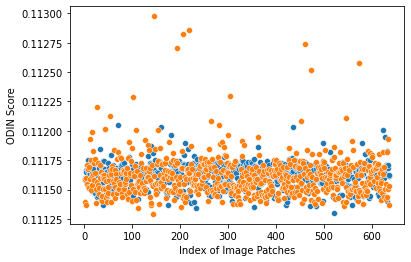

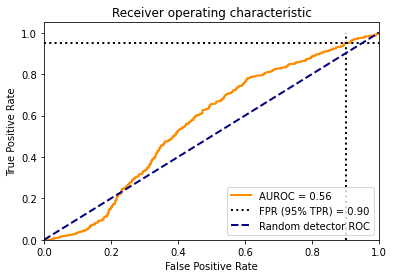

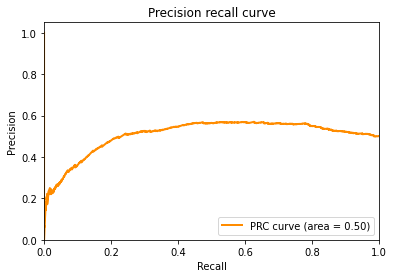

In [16]:
test_ODIN(cnn, 1000, perturb = 'gaussian')

{'fpr_at_95_tpr': 0.9842767295597484, 'detection_error': 0.4992138364779874, 'auroc': 0.33439391242435035, 'aupr_out': 0.38959733574471, 'aupr_in': 0.4034684129212746}


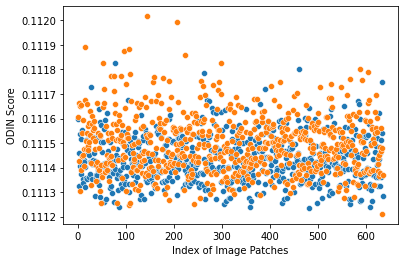

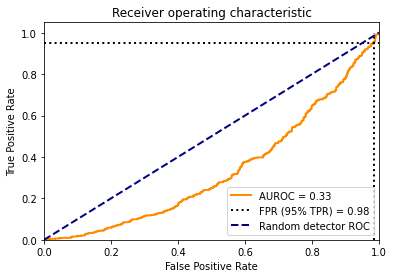

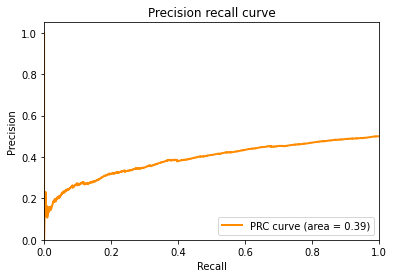

In [17]:
test_ODIN(cnn, 1000, perturb = 's&p')